In [1]:
import tensorflow as tf
import numpy as np
import os
from performance_prediction_model import Model
from sklearn.externals import joblib
import numpy as np
import pandas as pd
import dataprep
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import prediction

In [44]:
predict = '1080ti'

model_name = 'only_%s' %predict


model = 'no_%s' %predict
path = '/Users/djustus/workspace/newcastle/deep-learning-performance-evaluation/src/models/data'

In [45]:
scaler = joblib.load('models/%s/scaler_Conv.save'%model)
df = pd.read_pickle('data/Data_convolution_%s.pkl' %model_name)
tfmodel_file = 'models/%s/saved_model' %model

In [46]:
df.describe()

,batchsize,channels_in,channels_out,gpu,kernelsize,matsize,padding,precision,strides,timeUsed_max,...,opt_SGD,act_None,act_relu,act_sigmoid,act_tanh,peak_performance,IO,bandwidth,cores,clock
count,19641.000000,19641.000000,19641.000000,19641.0,19641.000000,19641.000000,19641.000000,19641.0,19641.000000,19641.000000,...,19641.000000,19641.000000,19641.000000,19641.000000,19641.000000,19641.0,19641.00,19641.0,19641.0,19641.0
mean,16.424775,64.909271,64.457971,0.0,3.994196,255.585154,0.497836,32.0,2.503335,8.082480,...,0.084873,0.247951,0.247849,0.254213,0.249987,10609.0,15.75,484.0,3584.0,1582.0
std,9.240791,309.867114,315.392422,0.0,2.007386,147.321147,0.500008,0.0,1.116166,13.157871,...,0.278700,0.431834,0.431775,0.435429,0.433016,0.0,0.00,0.0,0.0,0.0
min,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.000000,32.0,1.000000,0.155821,...,0.000000,0.000000,0.000000,0.000000,0.000000,10609.0,15.75,484.0,3584.0,1582.0
25%,8.000000,10.000000,10.000000,0.0,2.000000,129.000000,0.000000,32.0,2.000000,1.168780,...,0.000000,0.000000,0.000000,0.000000,0.000000,10609.0,15.75,484.0,3584.0,1582.0
50%,16.000000,19.000000,19.000000,0.0,4.000000,255.000000,0.000000,32.0,2.000000,2.994204,...,0.000000,0.000000,0.000000,0.000000,0.000000,10609.0,15.75,484.0,3584.0,1582.0
75%,24.000000,39.000000,38.000000,0.0,6.000000,383.000000,1.000000,32.0,4.000000,9.112101,...,0.000000,0.000000,0.000000,1.000000,0.000000,10609.0,15.75,484.0,3584.0,1582.0
max,32.000000,9959.000000,9858.000000,0.0,7.000000,512.000000,1.000000,32.0,4.000000,222.853065,...,1.000000,1.000000,1.000000,1.000000,1.000000,10609.0,15.75,484.0,3584.0,1582.0


In [47]:
data_cols_conv = ['batchsize','elements_matrix','elements_kernel','channels_in','channels_out','padding','strides','use_bias', 
                      'opt_SGD','opt_Adadelta','opt_Adagrad','opt_Momentum','opt_Adam','opt_RMSProp',
                      'act_relu','act_tanh','act_sigmoid',
#                       'ops','memory_weights','memory_in','memory_out',
                      'bandwidth','cores','clock']
split=[0,0,1]

In [48]:
data, time, train, test, validation = dataprep.data_preprocess_keep(df,data_cols_conv,split,scaler)

Size of train dataset: 0 
Size of test dataset: 0 
Size of validation dataset: 19641


/Users/djustus/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


INFO:tensorflow:Restoring parameters from models/no_1080ti/saved_model/variables/variables


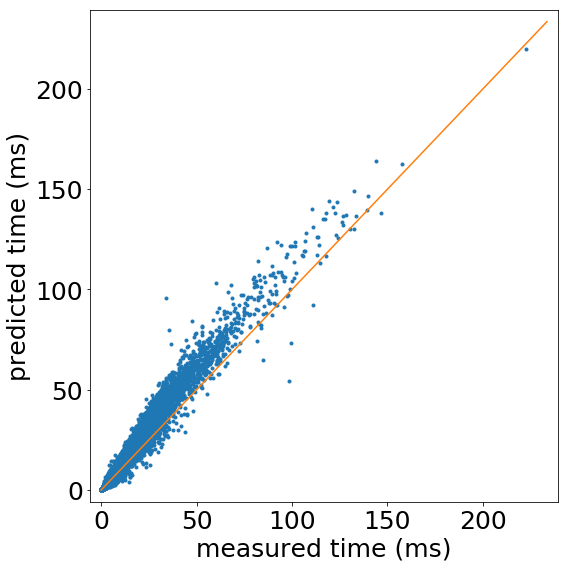

In [49]:
with tf.Session() as sess:
    tf.saved_model.loader.load(sess, ["serve"], tfmodel_file)
    graph = tf.get_default_graph()


    run = sess.run(
            'model_prediction:0',
            feed_dict={'model_input:0': data['Validation'], 
                       'model_targets:0': time['Validation'],
                       'model_istraining:0': False})
RMS_validation_error=np.sqrt(np.mean((time['Validation']-run)**2))
perc_error = np.mean(np.abs(time['Validation']-run)/time['Validation'])*100

fig,ax = plt.subplots(1,1,figsize=[8,8])
ax.plot(time['Validation'],run,'.')


ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())

matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 

plt.xlabel('measured time (ms)',fontsize=25)
plt.ylabel('predicted time (ms)',fontsize=25)


axlim = max(plt.xlim()[1],plt.ylim()[1])


#plt.axis('equal')
ax.set_xlim(-axlim*.025,axlim*1.025)
ax.set_ylim(-axlim*.025,axlim*1.025)

plt.tight_layout()
ax.ticklabel_format(useOffset=False)
ax.plot([0,axlim],[0,axlim],2)
#plt.title('RMS error = %.3f' %RMS_validation_error)

plt.savefig('figures/prediction_%s_from_other.png' %predict, dpi=300)

plt.show()

In [50]:
RMS_validation_error

4.244198

In [51]:
perc_error

25.55464208126068